# Example of Comparing Final Models Using Cross-Validation

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Lab Overview

In this lab, we develop three models—Ordinary Least Squares (OLS), Lasso regression, and Random Forests—to predict log-salary. To ensure a fair, apples-to-apples comparison, we evaluate all three models using the same folds in a five-fold cross-validation. Because each of the models below uses the same set of predictors, the comparison is relatively straightforward. However, if your final models rely on different subsets of predictors, coordinating a consistent cross-validation framework becomes a bit more involved.

## The Hitters Dataset

The **Hitters dataset** contains information about **Major League Baseball (MLB) players**, including their **career and recent performance statistics** and **annual salaries** in 1986.

- **Observations (rows):** 322 players  
- **Variables (columns):** 20 numerical and categorical features  

### Key Variables
- **AtBat**: Number of times at bat in the previous year  
- **Hits**: Number of hits in the previous year  
- **HmRun**: Number of home runs in the previous year  
- **Runs**: Number of runs scored in the previous year  
- **RBI**: Number of runs batted in (RBIs) in the previous year  
- **Walks**: Number of walks in the previous year  
- **Years**: Number of years the player has been in the major leagues  
- **CAtBat**, **CHits**, **CHmRun**, **CRuns**, **CRBI**, **CWalks**: Career totals for the corresponding statistics  
- **League**: League the player was in at the end of the previous season (*A* or *N*)  
- **Division**: Player’s division (*E* or *W*)  
- **PutOuts**, **Assists**, **Errors**: Fielding statistics  
- **Salary**: Player’s annual salary (in thousands of dollars)  
- **NewLeague**: League the player will play in the next season (*A* or *N*)  


## Load and Explore the Hitters Dataset

In the data directory, you will find the csv file for the dataset: `Hitters.csv`.

Run the two code cells below.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
datadir = "compareData"
hitters_path = os.path.join(datadir, "Hitters.csv")

hitters_df = pd.read_csv(hitters_path)

**Run the code cell below to check for missing values.**

In [4]:
hitters_df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

Note that the `Salary` variable is missing for **59 players**.  Since our goal is to **predict salary**, we cannot include observations with missing target values.  Therefore, we will **remove all rows where `Salary` is missing** before proceeding with our analysis.

**Run the code cell below to drop the rows where `Salary` is missing.**


In [5]:
# Drop rows were Salary is missing
hitters_df = hitters_df.dropna(subset=["Salary"])

# Verify there are no missing values
hitters_df.isnull().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

Recall that **salaries are typically right-skewed** because a small number of professional athletes earn extremely high incomes, while most players earn much less.  This pattern is common in income data, where compensation is unevenly distributed.

To make the distribution more symmetric and suitable for modeling, we often work with the **logarithm of salary** rather than the raw values.

**Run the code cell below to create histograms of `Salary` and `log(Salary)` to visualize how the log transformation affects the distribution.**


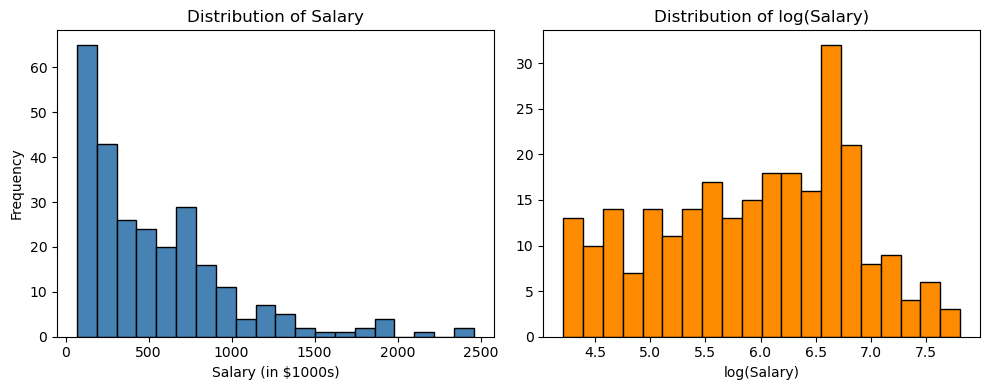

In [6]:
# Compute log of Salary (add small constant to avoid log(0) for missing or zero values)
log_salary = np.log(hitters_df["Salary"].dropna() + 1e-5)

# Create side-by-side histograms
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(hitters_df["Salary"].dropna(), bins=20, color="steelblue", edgecolor="black")
plt.title("Distribution of Salary")
plt.xlabel("Salary (in $1000s)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(log_salary, bins=20, color="darkorange", edgecolor="black")
plt.title("Distribution of log(Salary)")
plt.xlabel("log(Salary)")

plt.tight_layout()
plt.show()

## Create a Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

# Explicit numeric predictors (exclude categorical League/Division/NewLeague and the response)
X = hitters_df[[
    "AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks",
    "Years", "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI",
    "CWalks", "PutOuts", "Assists", "Errors"
]]
y = np.log(hitters_df["Salary"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=8
)

## Train Multiple Regression on Numeric Predictors

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on test set
y_pred = linreg.predict(X_test)

# Compute R^2
r2_test = r2_score(y_test, y_pred)
print(f"Linear Regression Test R^2: {r2_test:.3f}")

Linear Regression Test R^2: 0.523


## Train Lasso Regression Model on Same Numeric Predictors

Best lambda (alpha) for Lasso: 0.0292


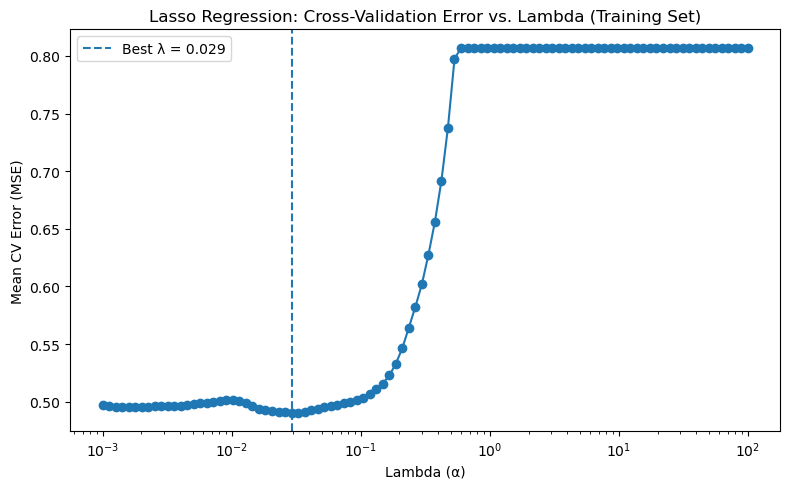

Lasso Test R^2 (best alpha): 0.568


In [9]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# --- Standardize using TRAINING DATA only ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Lasso with cross-validation on TRAINING SET ---

# 1) Range of alpha (lambda) values
alphas = np.logspace(-3, 2, 100)  # 0.001 → 100

# 2) 5-fold CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 3) Grid search over alpha
gs_lasso = GridSearchCV(
    estimator=Lasso(max_iter=10000),
    param_grid={"alpha": alphas},
    scoring="neg_mean_squared_error",
    cv=cv,
    return_train_score=True,
)

# 4) Fit on TRAINING data only
gs_lasso.fit(X_train_scaled, y_train)

# 5) Best alpha (lambda)
best_alpha_lasso = gs_lasso.best_params_["alpha"]
print(f"Best lambda (alpha) for Lasso: {best_alpha_lasso:.4f}")

# 6) CV curve (optional, but useful)
mean_cv_mse_lasso = -gs_lasso.cv_results_["mean_test_score"]

plt.figure(figsize=(8, 5))
plt.semilogx(alphas, mean_cv_mse_lasso, marker="o")
plt.axvline(best_alpha_lasso, linestyle="--", label=f"Best λ = {best_alpha_lasso:.3f}")
plt.xlabel("Lambda (α)")
plt.ylabel("Mean CV Error (MSE)")
plt.title("Lasso Regression: Cross-Validation Error vs. Lambda (Training Set)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Refit best Lasso on full TRAINING set and evaluate on TEST set ---

best_lasso = Lasso(alpha=best_alpha_lasso, max_iter=10000)
best_lasso.fit(X_train_scaled, y_train)

y_test_pred = best_lasso.predict(X_test_scaled)

# Compute and print Test R^2
r2_test_lasso = r2_score(y_test, y_test_pred)
print(f"Lasso Test R^2 (best alpha): {r2_test_lasso:.3f}")

## Train Random Forest Model on Same Numeric Predictors

In [10]:
from sklearn.ensemble import RandomForestRegressor

# Calculate number of predictors
p = X_train.shape[1]
m = max(1, p // 3)
print(f"Number of predictors (p): {p}, max_features (m): {m}")

# Random Forest model (same training set as OLS)
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_features=m,
    random_state=1
)

# Fit on training data
rf_model.fit(X_train, y_train)

# Predict on test set
y_hat_rf = rf_model.predict(X_test)

# Compute R²
r2_rf = r2_score(y_test, y_hat_rf)
print(f"Random Forest Test R²: {r2_rf:.3f}")


Number of predictors (p): 16, max_features (m): 5
Random Forest Test R²: 0.866


## Five-Fold Cross-Validation for Apples-to-Apples Comparisons

In [11]:
# Pull hyperparameters from existing models
chosen_alpha = best_lasso.alpha
n_trees = rf_model.n_estimators
max_feats = rf_model.max_features
rf_random_state = rf_model.random_state

# 1) Set up 5-fold cross-validation (same folds for all models)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 2) Prepare lists to store R² scores
ols_r2_scores = []
lasso_r2_scores = []
rf_r2_scores = []

# 3) Loop over folds
for train_index, test_index in kf.split(X):
    # Split data
    X_train_cv = X.iloc[train_index]
    X_test_cv  = X.iloc[test_index]
    y_train_cv = y.iloc[train_index]
    y_test_cv  = y.iloc[test_index]

    # ----- OLS (no standardization) -----
    ols = LinearRegression()
    ols.fit(X_train_cv, y_train_cv)
    y_pred_ols = ols.predict(X_test_cv)
    ols_r2_scores.append(r2_score(y_test_cv, y_pred_ols))

    # ----- Lasso (with standardization) -----
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_cv)
    X_test_scaled  = scaler.transform(X_test_cv)

    lasso = Lasso(alpha=chosen_alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train_cv)
    y_pred_lasso = lasso.predict(X_test_scaled)
    lasso_r2_scores.append(r2_score(y_test_cv, y_pred_lasso))

    # ----- Random Forest (no standardization) -----
    rf = RandomForestRegressor(
        n_estimators=n_trees,
        max_features=max_feats,
        random_state=rf_random_state,
    )
    rf.fit(X_train_cv, y_train_cv)
    y_pred_rf = rf.predict(X_test_cv)
    rf_r2_scores.append(r2_score(y_test_cv, y_pred_rf))

# 4) Compute means and standard deviations
ols_mean  = np.mean(ols_r2_scores)
ols_std   = np.std(ols_r2_scores)

lasso_mean = np.mean(lasso_r2_scores)
lasso_std  = np.std(lasso_r2_scores)

rf_mean   = np.mean(rf_r2_scores)
rf_std    = np.std(rf_r2_scores)

#print("Average R² across 5-fold CV:")
#print(f"OLS:           mean = {ols_mean:.3f}, std = {ols_std:.3f}")
#print(f"Lasso:         mean = {lasso_mean:.3f}, std = {lasso_std:.3f}")
#print(f"Random Forest: mean = {rf_mean:.3f}, std = {rf_std:.3f}")

# 5) Put results into a DataFrame
results_df = pd.DataFrame({
    "Model": ["OLS", "Lasso", "Random Forest"],
    "Mean_R2": [ols_mean, lasso_mean, rf_mean],
    "Std_R2": [ols_std, lasso_std, rf_std]
})

print("\nCross-validated R² summary:")
print(results_df)


Cross-validated R² summary:
           Model   Mean_R2    Std_R2
0            OLS  0.421757  0.067284
1          Lasso  0.436457  0.066156
2  Random Forest  0.755990  0.053271
